<a href="https://colab.research.google.com/github/mcpinto1993/Kaggle_StoreSales/blob/main/StoreSalesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📝Store Sales Analysis⏳ Time Serie**

### **Load Data From Kaggle**

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download store-sales-time-series-forecasting

! unzip store-sales-time-series-forecasting.zip

### **Load Packages**

In [15]:
# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings
import datetime as dt

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### **Read Data**

In [52]:
oil = pd.read_csv('/content/oil.csv')
stores = pd.read_csv('/content/stores.csv')
transactions = pd.read_csv('/content/transactions.csv')
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')
holidays_events = pd.read_csv('/content/holidays_events.csv')

### **Stores Analysis**

In [4]:
print("Column Types:\n{} \n".format(stores.dtypes))
print("DataFrame statistics: \n {} \n".format(stores.describe()))
print("Null Values: \n{} \n".format(stores.isnull().sum()))
print("Unique Values: \n{}".format(stores.nunique()))

Column Types:
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object 

DataFrame statistics: 
        store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000 

Null Values: 
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64 

Unique Values: 
store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64


In [5]:
#Total Nr of Stores -- 54
Total_NrStores = len(stores['store_nbr'].unique())

#Nr Of Stores By City, State and Type
NrStoresByCity = stores['city'].value_counts()
NrStoresByState = stores['state'].value_counts()
NrStoresByType = stores['type'].value_counts()

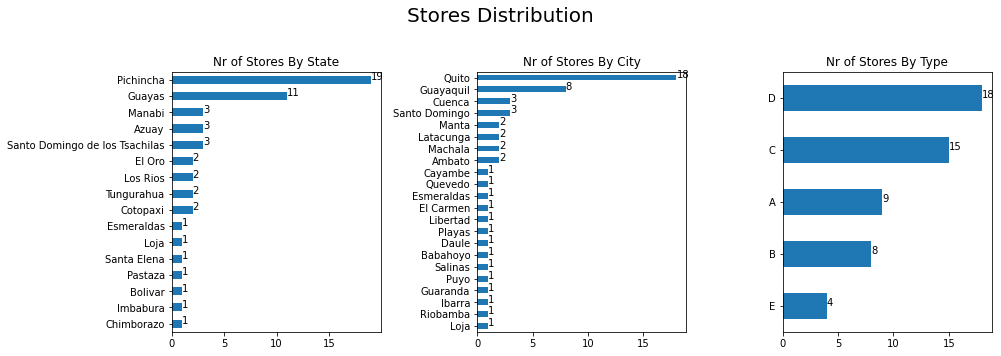

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.subplot(1,3,1)
NrStoresByState.sort_values().plot(kind='barh', figsize = (14,5), edgecolor = 'none')
plt.title("Nr of Stores By State")
for index, value in enumerate(NrStoresByState.sort_values()):
    plt.text(value, index,
             str(value))

plt.subplot(1,3,2)
NrStoresByCity.sort_values().plot(kind='barh', figsize = (14,5))
plt.title("Nr of Stores By City")
for index, value in enumerate(NrStoresByCity.sort_values()):
    plt.text(value, index,
             str(value))

plt.subplot(1,3,3)
NrStoresByType.sort_values().plot(kind='barh', figsize = (14,5))
plt.title("Nr of Stores By Type")
for index, value in enumerate(NrStoresByType.sort_values()):
    plt.text(value, index,
             str(value))

plt.tight_layout()
fig.suptitle("Stores Distribution", fontsize=20)
fig.subplots_adjust(hspace=0.4, top=0.8)
plt.show()

### **Transactions and Sales (train dataset)**

In [ ]:
print(transactions.head())
print(train.head())

In [ ]:
print("Column Types:\n{} \n".format(transactions.dtypes))
print("DataFrame statistics: \n {} \n".format(transactions.describe()))
print("Null Values: \n{} \n".format(transactions.isnull().sum()))
print("Unique Values: \n{}".format(transactions.nunique()))

In [69]:
#Join the DataFrames with Key Date/Store_nbr
train_trans = pd.merge(train.groupby(['date', 'store_nbr']).sales.sum().reset_index(), transactions, on=['date', 'store_nbr'], how = 'inner')

#Nr Of Transactions By Store
NrTransByStore = transactions[['store_nbr', 'transactions']].groupby(['store_nbr']).sum().sort_values(by='transactions', ascending = False).reset_index()

#Nr Of Transactions By Year, Month, DayOftheWeek
transactions['Year'] = pd.to_datetime(transactions['date']).dt.year
transactions['Month'] = pd.to_datetime(transactions['date']).dt.strftime('%b')
transactions['WeekDay'] = pd.to_datetime(transactions['date']).dt.strftime('%a')

#TransactionsMonth
TransactionsMean = transactions[['date','Month', 'Year', 'transactions']].groupby(['date','Month','Year']).mean().reset_index()

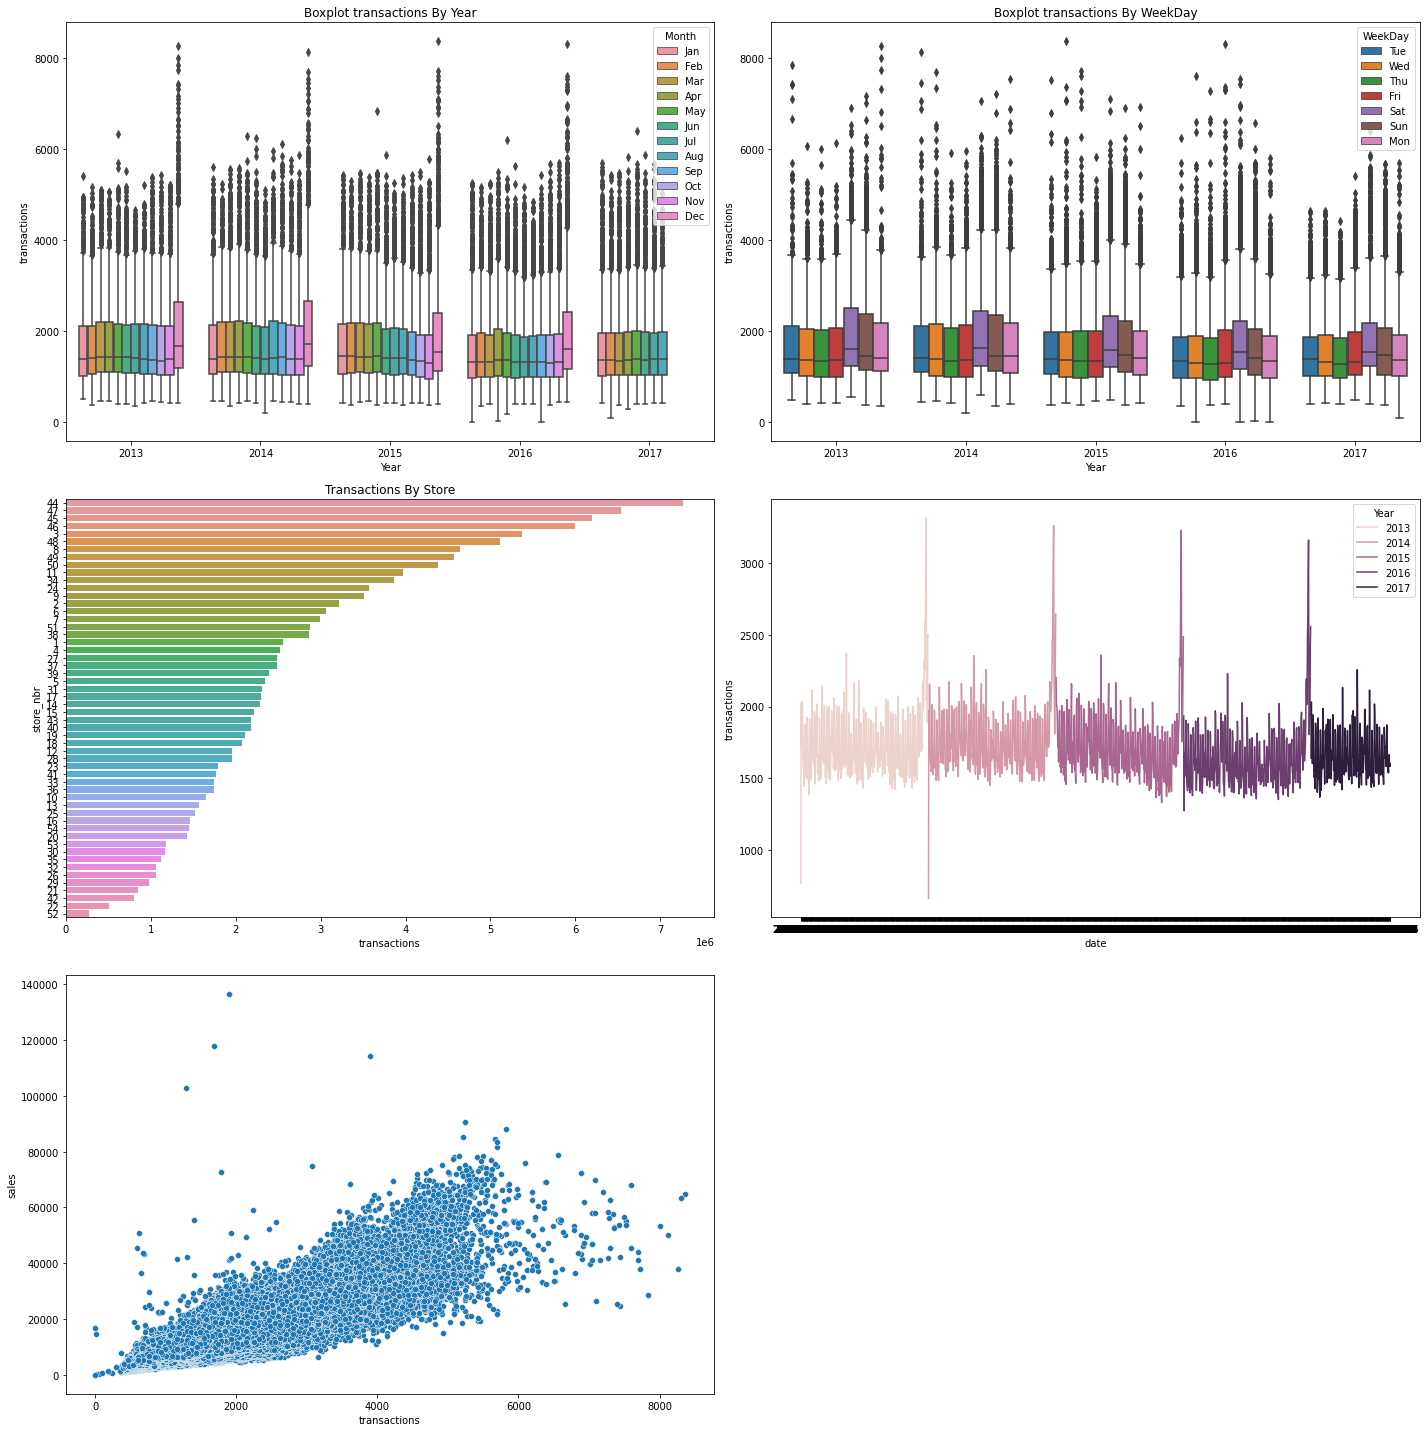

In [74]:
fig = plt.figure(figsize=(20, 20))

#Subplot 1 -- Boxplot Transactions By Month/Year
ax1 = fig.add_subplot(3, 2, 1)
ax1 = sns.boxplot(y=transactions['transactions'], x=transactions['Year'], hue = transactions['Month'])
ax1.set_title('Boxplot transactions By Year')

#Subplot 2 -- Boxplot Transactions By WeekDay
ax2 = fig.add_subplot(3, 2, 2)
ax2 = sns.boxplot(y=transactions['transactions'], x=transactions['Year'], hue = transactions['WeekDay'])
ax2.set_title('Boxplot transactions By WeekDay')

#Subplot 3 -- Barplot Nr Of Transactions By Store
ax3 = fig.add_subplot(3, 2, 3)
ax3 = sns.barplot(x=NrTransByStore['transactions'], y=NrTransByStore['store_nbr'], orient='h', order=NrTransByStore.sort_values(by='transactions', ascending = False).store_nbr)
ax3.set_title('Transactions By Store')

#Subplot 4 -- LinePlot nr of Transactions By Date/Year
ax4 = fig.add_subplot(3,2,4)
ax4 = sns.lineplot(data=TransactionsMean, x='date', y='transactions', hue = 'Year')

#Subplot 5 -- Scatterplot Transactions/Sales
ax5 = fig.add_subplot(3,2,5)
ax5 = sns.scatterplot(data=train_trans, x='transactions', y='sales')

plt.tight_layout()

### **Train DataSet**

In [13]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
